# Proyecto. Predicción de precios de acciones.

## Descarga de datos
Si aún no cuentas con los datos, puedes descargarlos con el siguiente código.
Los datos deben estar en la carpeta `data`.

In [243]:
#import kagglehub

# Download latest version
#path = kagglehub.dataset_download("paultimothymooney/stock-market-data")

#print("Path to dataset files:", path)

Coloca los datos en la carpeta `data` y asegúrate de que la estructura de carpetas sea la siguiente:
```terminal
data
└── stock_market_data
    ├── forbes2000
    │   ├── csv
    │   └── json
    ├── nasdaq
    │   ├── csv
    │   └── json
    ├── nyse
    │   ├── csv
    │   └── json
    └── sp500
        ├── csv
        └── json
```



## Lectura de datos
Para este proyecto, usaremos los datos de la bolsa de valores de Nueva York (NYSE) del archivo `BEN.csv`.


Primero vamos a ponerlo en un dataframe de pandas.


In [244]:
import pandas as pd


base_path = 'data/stock_market_data/forbes2000/csv/IP.csv'

#Otras opciones de CSVs
#base_path = 'data/stock_market_data/sp500/csv/VZ.csv'

#base_path = 'data/stock_market_data/nyse/csv/X.csv'

#base_path = 'data/stock_market_data/nyse/csv/BEN.csv'





# 1) Leer CSV indicándole que el día viene primero
df = pd.read_csv(
    base_path,
    parse_dates=['Date'],
    dayfirst=True,           # <-- aquí
)

# 2) Ordenar por fecha y fijar índice
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)

# 3) Verifica columnas y elimininamos 'Adjusted Close'
print("Columnas originales:", df.columns.tolist())
df.drop(columns=['Adjusted Close'], inplace=True)

print(df.head())
print("Columnas finales:", df.columns.tolist())

print(df.tail())


Columnas originales: ['Low', 'Open', 'Volume', 'High', 'Close', 'Adjusted Close']
                 Low      Open  Volume      High     Close
Date                                                      
1970-01-02  8.638530  8.667714   75812  8.959557  8.930373
1970-01-05  9.076294  9.076294  125068  9.338952  9.251399
1970-01-06  9.105478  9.251399   89089  9.280583  9.163846
1970-01-07  8.901188  9.134662   98940  9.134662  8.959557
1970-01-08  8.988741  8.988741   78381  9.076294  9.047109
Columnas finales: ['Low', 'Open', 'Volume', 'High', 'Close']
                  Low       Open   Volume       High      Close
Date                                                           
2022-12-06  36.029999  36.419998  2218700  36.740002  36.419998
2022-12-07  36.029999  36.150002  2003600  36.730000  36.150002
2022-12-08  36.020000  36.389999  1487400  36.529999  36.169998
2022-12-09  36.009998  36.380001  1744400  36.529999  36.080002
2022-12-12  35.945000  36.070000   411819  36.345001  36.305

Vamos a ordenar por fecha y a definir nuestras caracteristicas de entrada:
- `Open`, `High`, `Low`, `Volume`.

Y para la salida
- `Close`.


#### Preparación de datos
Primero vamos normalizar los datos de las caracteristicas de entrada, despues creamos ventanas de tiempo para las caracteristicas de entrada con tamaño T. 

In [245]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader

# 1) Parámetros
T = 10                         # largo de la secuencia
features = ['Open','High','Low','Volume']
target   = 'Close'

# 2) Extraer matrices NumPy
data_X = df[features].values   # forma (n_días, D)
data_y = df[target].values     # forma (n_días,)




# 3) Normalizar 
scaler = StandardScaler()
data_X = scaler.fit_transform(data_X)



# 4) Construir ventanas deslizantes
X, y = [], []
for i in range(len(df) - T):
    X.append(data_X[i:i+T])       # cada X_i es (T, D)
    y.append(data_y[i+T])         # el cierre “del día siguiente”
X = np.stack(X)                    # forma (N, T, D)
y = np.array(y)                    # forma (N,)

# 5) Convertir a tensores PyTorch
X_tensor = torch.from_numpy(X).float()            # float32
y_tensor = torch.from_numpy(y).float().unsqueeze(1)  # (N,1)

# 6) Separar train/test 
N = X_tensor.size(0)
# 60% para entrenamiento, 20% validación, 20% test
n_train = int(0.60 * N)
n_val   = int(0.20 * N)
n_test  = N - n_train - n_val

# Crear los TensorDataset correspondientes
train_ds = TensorDataset(X_tensor[:n_train],       y_tensor[:n_train])
val_ds   = TensorDataset(X_tensor[n_train:n_train+n_val],
                         y_tensor[n_train:n_train+n_val])
test_ds  = TensorDataset(X_tensor[n_train+n_val:], y_tensor[n_train+n_val:])

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

print(f"Ejemplares totales: {N}")
print(f"Train: {len(train_ds)}  |  Val: {len(val_ds)}  |  Test: {len(test_ds)}")
print(f"Batches por loader -> Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")



Ejemplares totales: 13346
Train: 8007  |  Val: 2669  |  Test: 2670
Batches por loader -> Train: 251, Val: 84, Test: 84


## Red LSTM 

Vamos a crear una red LSTM para predecir el precio de las acciones.

In [246]:
import torch
import torch.nn as nn

class StockLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1, dropout=0.0):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Capa LSTM: recibe secuencias de largo T con input_dim features
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers>1 else 0.0
        )

        # Capa final: de hidden_dim a 1 valor de salida (regresión)
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: (batch, T, input_dim)
        # h0, c0 se inicializan a cero
        batch_size = x.size(0)
        device = x.device
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=device)

        # LSTM → output: (batch, T, hidden_dim)
        out, (hn, cn) = self.lstm(x, (h0, c0))

        # Tomamos sólo la salida en el último paso de tiempo
        last = out[:, -1, :]  # forma (batch, hidden_dim)

        # Y la pasamos por la linear
        y_pred = self.linear(last)  # forma (batch, 1)
        return y_pred


Epoch 10 — Train Loss: 0.6347 | Val Loss: 0.7214
Epoch 20 — Train Loss: 0.5190 | Val Loss: 0.6272
Epoch 30 — Train Loss: 0.4725 | Val Loss: 0.5758
Epoch 40 — Train Loss: 0.4553 | Val Loss: 0.5727
Epoch 50 — Train Loss: 0.4247 | Val Loss: 0.5700


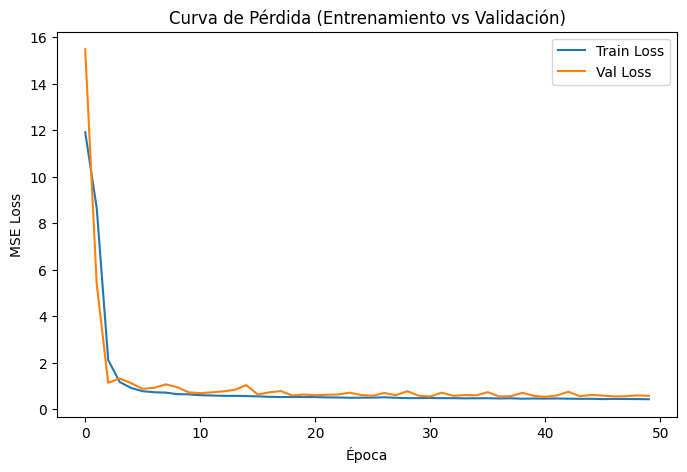

In [247]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# ── 0) Fijar semilla para reproducibilidad ────────────────────────────────────
seed = 100
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


# 1) Hiperparámetros
input_dim  = len(features)  
hidden_dim = 100
num_layers = 3
dropout    = 0.1
lr         = 1e-3
epochs     = 50
batch_size = 32

# Fuerza uso de CPU si tu instalación de CUDA da problemas:
# device = torch.device('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2) Modelo, pérdida y optimizador
model = StockLSTM(input_dim, hidden_dim, num_layers, dropout=dropout).to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# 3) Listas para almacenar métricas
train_losses, val_losses = [], []

# 4) Bucle de entrenamiento
for epoch in range(1, epochs+1):
    # --- Entrenamiento ---
    model.train()
    running_train = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        running_train += loss.item() * xb.size(0)

    epoch_train_loss = running_train / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # --- Validación ---
    model.eval()
    running_val = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            running_val += criterion(outputs, yb).item() * xb.size(0)

    epoch_val_loss = running_val / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    # Imprimir en consola

    # --- Graficar cada 10 épocas y al final ---
    if epoch % 10 == 0 or epoch == epochs:
        print(f"Epoch {epoch:02d} — Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")



# ── 5) Gráfica final de pérdidas ──────────────────────────────────────────────
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val Loss')
plt.xlabel("Época")
plt.ylabel("MSE Loss")
plt.title("Curva de Pérdida (Entrenamiento vs Validación)")
plt.legend()
plt.show()

## Prueba de la red

In [248]:
model.eval()
test_loss = 0.0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        out = model(xb)
        test_loss += criterion(out, yb).item() * xb.size(0)
test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")


Test Loss: 0.8819


Predicciones vs valores reales.

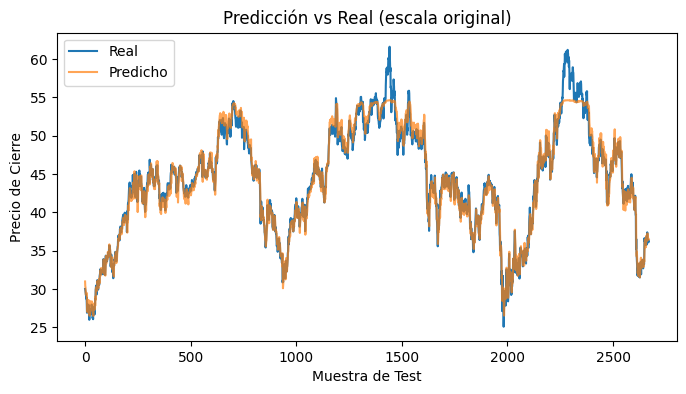

In [249]:
model.eval()
ys_true, ys_pred = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        # yb viene en escala original, así que:
        y_pred = model(xb).cpu().numpy().flatten()
        ys_pred.extend(y_pred)
        ys_true.extend(yb.numpy().flatten())

# Graficar directamente en la escala de precios reales
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(ys_true, label='Real')
plt.plot(ys_pred, label='Predicho', alpha=0.7)
plt.xlabel("Muestra de Test")
plt.ylabel("Precio de Cierre")
plt.title("Predicción vs Real (escala original)")
plt.legend()
plt.show()


Accuracy subida/bajada en Test: 99.48%


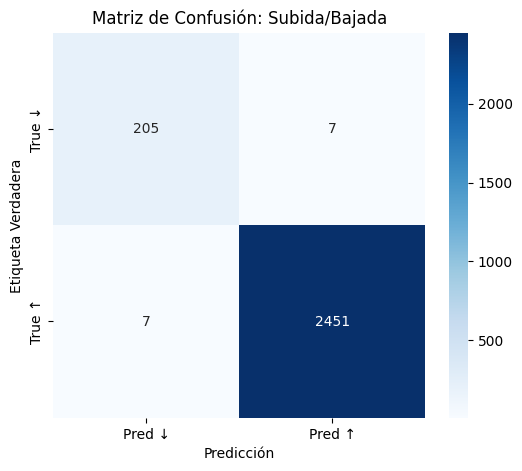

In [250]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Supón que ya tienes:
# - 'ys_true': array con precios reales del test set (escala original)
# - 'ys_pred': array con precios predichos por tu modelo (escala original)
# - 'df': DataFrame original con la columna 'Close'
# - 'T', 'n_train' definidos igual que en tu script

# 1) Reconstruir cierres "previos" al test para obtener la etiqueta de subida/bajada
close_values = df['Close'].values
test_start   = n_train + T
test_len     = len(ys_true)
test_indices = np.arange(test_start, test_start + test_len)
prev_close   = close_values[test_indices - 1]

# 2) Crear etiquetas verdaderas y predichas
true_labels = (ys_true > prev_close).astype(int)
pred_labels = (ys_pred > prev_close).astype(int)

# 3) Calcular accuracy
accuracy = (true_labels == pred_labels).mean()
print(f"Accuracy subida/bajada en Test: {accuracy*100:.2f}%")

# 4) Calcular matriz de confusión
cm = confusion_matrix(true_labels, pred_labels)

# 5) Graficar con seaborn
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred ↓','Pred ↑'],
            yticklabels=['True ↓','True ↑'])
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión: Subida/Bajada')
plt.show()


